
# データ
- 10フォルダl_goalのみ
- 訓練データ5708
- テストデータ1424

# モデル
双方向LSTMでモデルを構築
- 中間層は64次元
- 200epoch
- batch_size=1024

# 結果
- models/model_20250212143450.pth
- val_loss: 0.1779
- 訓練時間は13分



In [1]:
import pandas as pd
import torch
import datasets
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import numpy as np
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn, optim
import visualizer

In [2]:
dataset = datasets.load_dataset(
    "ReonOhashi/RobocupTrajectoryPrediction_8team",
    revision="4b7442f81bf53d7d22af0d6ce6424a4acdf47df9",
)
dataset = dataset["train"]
train_raw, test_raw = dataset.train_test_split(test_size=0.2, seed=42).values()

In [3]:
len(train_raw), len(test_raw)

(13197, 3300)

In [ ]:
from typing import Union


def swap_rl(df):
    # swap data between left and right
    df["l_name"], df["r_name"] = df["r_name"], df["l_name"]
    df["b_x"] *= -1

    for i in range(1, 12):
        l_x, r_x = f"l{i}_x", f"r{i}_x"
        l_y, r_y = f"l{i}_y", f"r{i}_y"

        df[l_x], df[r_x] = -df[r_x].values, -df[l_x].values
        df[l_y], df[r_y] = df[r_y].values, df[l_y].values

    return df


# def to_np(df: Union[datasets.arrow_dataset.Dataset, list[pd.DataFrame]]) -> np.ndarray:
#     if isinstance(df, datasets.arrow_dataset.Dataset):
#         a = []
#         for data in tqdm(df):
#             df_data = pd.DataFrame(data)
#             goal_type = df_data["goal_type"].iloc[0]
#             df_data = df_data.drop(columns=["goal_type"]).values
#             if goal_type == "goal_l" or goal_type is None:
#                 a.append(df_data)
#             elif goal_type == "goal_r":
#                 a.append(swap_rl(pd.DataFrame(data)).drop(columns=["goal_type"]).values)
#             else:
#                 raise ValueError
#         return np.stack(a)
#     elif isinstance(df, list):
#         return np.stack([data.drop(columns=["goal_type"]).values for data in df])


def to_np(df: Union[datasets.arrow_dataset.Dataset, list[pd.DataFrame]]) -> np.ndarray:
    if isinstance(df, datasets.arrow_dataset.Dataset):
        a = []
        for data in tqdm(df):
            df_data = pd.DataFrame(data)
            goal_type = df_data["goal_type"].iloc[0]
            df_data = df_data.drop(columns=["goal_type"]).values
            if goal_type == "goal_l" or goal_type is None:
                a.append(df_data)
            elif goal_type == "goal_r":
                pass
                # a.append(swap_rl(pd.DataFrame(data)).drop(columns=["goal_type"]).values)
            else:
                raise ValueError
        return np.stack(a)
    elif isinstance(df, list):
        return np.stack([data.drop(columns=["goal_type"]).values for data in df])


def to_df(arrs):
    feature_columns = dataset.column_names
    columns = [col for col in feature_columns if col != "goal_type"]
    return [pd.DataFrame(arr, columns=columns).assign(goal_type=None) for arr in arrs]


train, test = to_np(train_raw), to_np(test_raw)
print(train.shape, test.shape)

  0%|          | 0/13197 [00:00<?, ?it/s]

  0%|          | 0/3300 [00:00<?, ?it/s]

(5708, 50, 49) (1424, 50, 49)


In [5]:
# remove nan and inf
print(train.shape, test.shape)  # (5708, 50, 49) (1424, 50, 49)

train = train[~np.isnan(train).any(axis=(1, 2))]
test = test[~np.isnan(test).any(axis=(1, 2))]

print(train.shape, test.shape)

(5708, 50, 49) (1424, 50, 49)
(5689, 50, 49) (1419, 50, 49)


In [6]:
def window(datas, time_step=20):
    X, y = [], []
    for data in tqdm(datas):
        for i in range(data.shape[0] - time_step):
            X.append(data[i : i + time_step])
            y.append(data[i + time_step])
            pass
    return np.array(X), np.array(y)


X_train, y_train = window(train)
X_test, y_test = window(test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

  0%|          | 0/5689 [00:00<?, ?it/s]

  0%|          | 0/1419 [00:00<?, ?it/s]

(170670, 20, 49) (170670, 49) (42570, 20, 49) (42570, 49)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# TensorDataset と DataLoader の作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 1024
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=16
)
val_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16
)

In [9]:
from pytorch_lightning.callbacks import ModelCheckpoint


class LossHistory(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            self.train_losses.append(train_loss.item())
        else:
            self.train_losses.append(None)

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.val_losses.append(val_loss.item())
        else:
            self.val_losses.append(None)


class LitBiLSTM(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.criterion = nn.MSELoss()
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        output = self.fc(last_out)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer


# チェックポイントのコールバックを定義（val_lossが改善したときに保存）
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="bilstm-{epoch:02d}-{val_loss:.4f}",
    save_top_k=3,
    mode="min",
)

# 損失の履歴を保存するコールバックを定義
loss_history = LossHistory()

trainer = pl.Trainer(
    max_epochs=200,
    accelerator="gpu",
    devices=1,
    callbacks=[checkpoint_callback, loss_history],
)


# X_train の shape が (サンプル数, timesteps, features) であることを前提
input_dim = X_train.shape[2]
hidden_dim = 64
output_dim = y_train.shape[1]
num_layers = 2

model = LitBiLSTM(input_dim, hidden_dim, output_dim, num_layers, lr=0.001)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


2025-02-12 13:57:03.651005: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 13:57:03.663491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739368623.677901  738379 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739368623.682606  738379 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 13:57:03.699066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


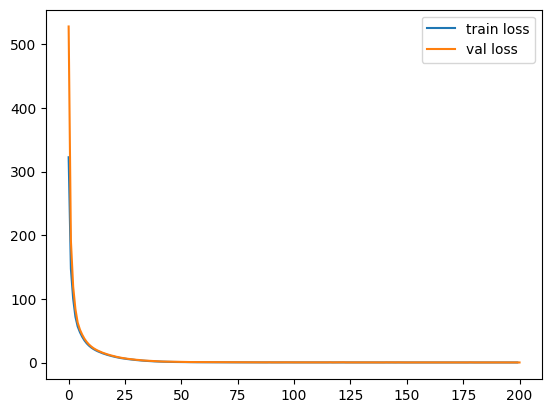

In [48]:
import matplotlib.pyplot as plt

plt.plot(loss_history.train_losses, label="train loss")
plt.plot(loss_history.val_losses, label="val loss")

plt.legend()

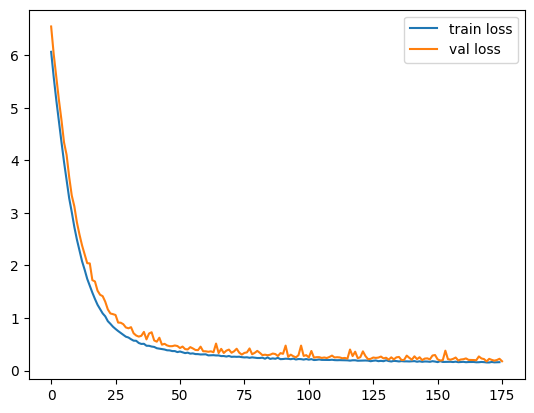

In [23]:
# loss の推移を確認

import matplotlib.pyplot as plt

plt.plot(loss_history.train_losses[25:], label="train loss")
plt.plot(loss_history.val_losses[25:], label="val loss")

plt.legend()

In [43]:
def check_test(test):
    X_test, y_test = window([test[0]])
    X_test = np.array([X_test[0]])
    X_test_t0 = X_test.copy()

    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    ans = []

    model.to(device)  # Move the model to the same device as the input tensor

    with torch.no_grad():
        for _ in tqdm(range(30)):
            out = model.forward(X_test)
            ans.append(out[0])
            X_test = torch.cat([X_test[:, 1:, :], out.unsqueeze(0)], dim=1)

    ans = torch.stack(ans).cpu().numpy()
    y_test = y_test.cpu().numpy()

    X_test_t0 = X_test_t0[0]
    # display(X_test_t0.shape)  # (20, 49)
    # display(ans.shape)  # (30, 49)
    # display(y_test.shape)  # (30, 49)

    ans = np.concatenate([X_test_t0, ans], axis=0)
    y_test = np.concatenate([X_test_t0, y_test], axis=0)

    # display(ans.shape)  # (50, 49)
    # display(y_test.shape)  # (50, 49)

    display(visualizer.visualizer_np2(y_test, ans))


check_test(test)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [55]:
import time

model_name = f"model_{time.strftime('%Y%m%d%H%M%S')}.pth"
# save model
torch.save(model.state_dict(), f"models/{model_name}")

# load model
model = LitBiLSTM(input_dim, hidden_dim, output_dim, num_layers, lr=0.001)
model.load_state_dict(torch.load(f"models/{model_name}"))
print(model_name)

model_20250212143450.pth


# サマリ
